# This notebook demonstrates how to:

1. Collect Reddit data using PMAW/PRAW
2. Do sentiment analysis using VADER
3. Do sentiment analysis using EMPATH

#### Credit: Darshan Satra (dsatra@iu.edu)



## 1. Script to collect data from Reddit using PMAW/PRAW

For installing praw:

In [3]:
!pip install praw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 6.8 MB/s eta 0:00:00


### How to get Reddit Developer Credentials

1. Go to www.reddit.com/prefs/apps/ or https://old.reddit.com/prefs/apps

2. Create a new script application.

3. Use the following value for Redirect uri: http://localhost:8080

4. Refer to https://praw.readthedocs.io/en/stable/getting_started/authentication.html#application-only-client-credentials-flow to understand the pieces of information needed for authentication (e.g. client_id, client_secret, etc.).


### A script for getting submissions from a particular subreddit between two dates and creating a dataframe out of it.

In [12]:
import praw
import pandas as pd
from datetime import datetime

# Initialize Reddit API client using PRAW
reddit = praw.Reddit(
    client_id='mqaw3qYOQqtDWnvUHFiUKg',
    client_secret='6bPat7wSc1DU5TN0bn4L30_tCDHIKQ',
    user_agent='test',\
    username='mozpt',
    password='Sumn@1234'
)

# Define submissions, their timelines, and categories
# Including number of comments and sort method:
submissions_info = {
    'zyucbm': {  # Best match in World cup 2022? Argentina - Holland
        'start': datetime(2022, 12, 29),
        'end': datetime(2023, 4, 30),
        'category': 'post',
        'subreddit': 'worldcup',
        'comment_limit': 172,  # "all 172 comments"
        'sort': 'all'         # all comments, no sorting by top
    },
    'zoz9vx': {  # [Match thread] Argentina vs France
        'start': datetime(2022, 12, 17),
        'end': datetime(2023, 4, 30),
        'category': 'post',
        'subreddit': 'worldcup',
        'comment_limit': 700, # top 700 comments
        'sort': 'top'
    },
    '12qqii8': { # Just four months ago...
        'start': datetime(2023, 4, 17),
        'end': datetime(2024, 4, 30),
        'category': 'post',
        'subreddit': 'worldcup',
        'comment_limit': 426, # all 426 comments
        'sort': 'all'
    },
    'ttwab9': {  # The stage is set for Qatar!
        'start': datetime(2022, 3, 30),
        'end': datetime(2022, 12, 1),
        'category': 'pre',
        'subreddit': 'worldcup',
        'comment_limit': 271, # all 271 comments
        'sort': 'all'
    },
    'zp43wc': {  # Argentina have won their third World Cup title...
        'start': datetime(2022, 12, 17),
        'end': datetime(2023, 5, 30),
        'category': 'post',
        'subreddit': 'soccer',
        'comment_limit': 600, # top 600 comments
        'sort': 'top'
    },
    'ypsmmp': { # EA SPORTS predicts Argentina...
        'start': datetime(2022, 11, 7),
        'end': datetime(2023, 5, 30),
        'category': 'pre',
        'subreddit': 'soccer',
        'comment_limit': 473, # all 473 comments
        'sort': 'all'
    },
    'zh3mwp': { # Croatia defeats Brazil...
        'start': datetime(2022, 12, 8),
        'end': datetime(2023, 5, 30),
        'category': 'pre',
        'subreddit': 'soccer',
        'comment_limit': 800, # top 800 comments
        'sort': 'top'
    },
    'zh9yru': { # Argentina defeats Netherlands...
        'start': datetime(2022, 12, 8),
        'end': datetime(2023, 5, 30),
        'category': 'pre',
        'subreddit': 'soccer',
        'comment_limit': 800, # top 800 comments
        'sort': 'top'
    }
}

# Lists to store data for pre and post categories
pre_data = []
post_data = []

def process_submission(sub_id, info):
    submission = reddit.submission(id=sub_id)

    # Set comment sort if needed
    if info['sort'] == 'top':
        submission.comment_sort = 'top'
    else:
        # Default sort is 'confidence'
        # If we want all comments, no special sorting needed.
        submission.comment_sort = 'confidence'

    submission.comments.replace_more(limit=0)

    sub_title = submission.title
    sub_author = submission.author.name if submission.author else '[deleted]'
    sub_score = submission.score
    sub_created_utc = submission.created_utc
    sub_permalink = 'https://www.reddit.com' + submission.permalink

    start_date = info['start']
    end_date = info['end']
    category = info['category']
    comment_limit = info['comment_limit']

    # Extract comments
    all_comments = submission.comments.list()

    # If sorting by top and a limit is provided, slice the first N comments.
    # If "all" was specified and that number matches the total known comments, just slice.
    # If fewer comments are available than requested, we take what's available.
    if comment_limit > 0:
        selected_comments = all_comments[:comment_limit]
    else:
        selected_comments = all_comments

    # Filter by timeframe
    for comment in selected_comments:
        comment_time = datetime.utcfromtimestamp(comment.created_utc)
        if start_date <= comment_time <= end_date:
            comment_body = comment.body
            comment_author = comment.author.name if comment.author else '[deleted]'
            comment_score = comment.score
            comment_created_utc = comment.created_utc
            row = [
                sub_id,
                sub_title,
                sub_author,
                sub_created_utc,
                sub_score,
                sub_permalink,
                comment_author,
                comment_body,
                comment_score,
                comment_created_utc
            ]
            if category == 'pre':
                pre_data.append(row)
            else:
                post_data.append(row)


# Process each submission
for sid, info in submissions_info.items():
    process_submission(sid, info)

columns = [
    'Submission_ID', 'Submission_Title', 'Submission_Author', 'Submission_Created_UTC',
    'Submission_Score', 'Submission_Permalink', 'Comment_Author', 'Comment_Body',
    'Comment_Score', 'Comment_Created_UTC'
]

pre_df = pd.DataFrame(pre_data, columns=columns)
post_df = pd.DataFrame(post_data, columns=columns)

# Write DataFrames to CSV files
pre_df.to_csv('pre_worldcup_sentiments.csv', index=False)
post_df.to_csv('post_worldcup_sentiments.csv', index=False)

print("Data extraction complete. 'pre_worldcup_sentiments.csv' and 'post_worldcup_sentiments.csv' have been created.")

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

Data extraction complete. 'pre_worldcup_sentiments.csv' and 'post_worldcup_sentiments.csv' have been created.


### A script for getting reddit posts containing a few keywords between two dates

In [ ]:
subreddit = 'learnpython'
keywords = ['IDE', 'Python']
start_date = datetime(2022, 1, 1)
end_date = datetime(2023, 1, 1)

data = []

for submission in reddit.subreddit(subreddit).search(f'{keywords}', limit=None):
    created_utc = submission.created_utc
    submission_date = datetime.utcfromtimestamp(created_utc)
    if start_date <= submission_date < end_date:
        title = submission.title
        author = submission.author.name if submission.author else '[deleted]'
        score = submission.score
        data.append([title, author, score, submission_date])

# Create a pandas DataFrame from the data
df = pd.DataFrame(data, columns=['Title', 'Author', 'Score', 'Date'])

# Write the DataFrame to a CSV file
df.to_csv('reddit_data.csv', index=False)

### A script for getting X number of Reddit comments under a specific post

In [ ]:
from praw.models import MoreComments
post_id = '1b2pexb'
num_comments = 100

post = reddit.submission(id=post_id)

comments = post.comments[:num_comments]

data = []

def getComments(comments):
    try:
        for comment in comments:
            if isinstance(comment,MoreComments):
                # This is a comment that has more comments inside it
                # We need to go through those sub comments
                getComments(comment.comments)
                continue
            author = comment.author.name if comment.author else '[deleted]'
            text = comment.body
            date = comment.created_utc
            score = comment.score
            data.append([author, text, date, score])
    except:
        print("")

getComments(comments)

# Create a pandas DataFrame from the data
df = pd.DataFrame(data, columns=['Author', 'Text', 'Date', 'Score'])

# Write the DataFrame to a CSV file
df.to_csv('reddit_data.csv', index=False)

## 2. Script for sentiment analysis using VADER

To install the package use this command:

In [ ]:
pip install vaderSentiment


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Script for VADER

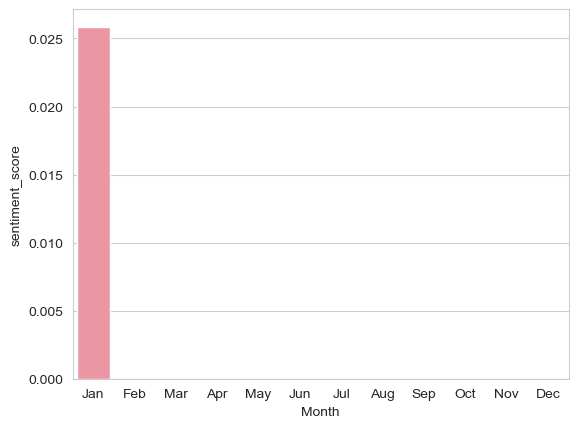

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import string
import seaborn as sns


df = pd.read_csv('reddit_data.csv')
df = df.loc[:,['Date','Text']]

sid_obj = SentimentIntensityAnalyzer()

# function to pre-precess
def preprocess_data(df):
    df["Text"] = df["Text"].apply(lambda x:x.translate(str.maketrans('','',string.punctuation)))
    df["Date"] = pd.to_datetime(df["Date"])
    df["Month"] = df['Date'].dt.strftime('%b')
    return df

# Compute sentiment and plot monthly score
def sentiment(df):
    sentiment_scores = []
    for text in df['Text']:
        scores = sid_obj.polarity_scores(text)
        sentiment_scores.append(scores['compound'])
    df['sentiment_score'] = sentiment_scores

    # Group by month and compute the mean sentiment score
    monthly_avg_sentiment = df.groupby('Month')['sentiment_score'].mean().reset_index()

    # Initialize a DataFrame with all months
    all_months = pd.DataFrame({'Month': pd.date_range(start='2022-01-01', end='2022-12-31', freq='MS').strftime('%b')})

    # Merge sentiment data with all months
    monthly_avg_sentiment = all_months.merge(monthly_avg_sentiment, on='Month', how='left')

    # Replace NaN values with 0
    monthly_avg_sentiment['sentiment_score'] = monthly_avg_sentiment['sentiment_score'].fillna(0)

    sns.set_style('whitegrid')
    sns.barplot(x='Month', y='sentiment_score', data=monthly_avg_sentiment)

df =preprocess_data(df)
sentiment(df)

## 3. Script for sentiment analysis using EMPATH

To install empath use this command:

In [ ]:
pip install empath

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for empath: filename=empath-0.89-py3-none-any.whl size=57800 sha256=8a2a2876adc0be3f06bf1d2ac739b6ce90ff5fd36eef1d8fdd57d2963bd9532e
  Stored in directory: /Users/darshansatra1/Library/Caches/pip/wheels/b5/93/85/f4e8694df404eb214060dd0e0f3fda14398638f5835b3dde23
Successfully built empath

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


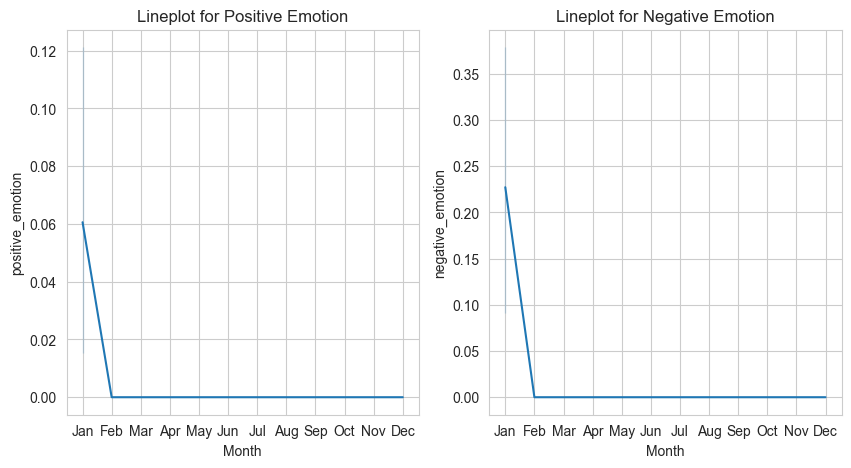

In [ ]:
import empath
import pandas as pd
import string
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.read_csv('reddit_data.csv')
df = df.loc[:,['Date','Text']]

lexicon = empath.Empath()
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(10,5))

def preprocess_data(df):
    df["Text"] = df["Text"].apply(lambda x:x.translate(str.maketrans('','',string.punctuation)))
    df["Date"] = pd.to_datetime(df["Date"])
    df["Month"] = df['Date'].dt.strftime('%b')
    return df

def sentiment(df):
    positive_emotion = []
    negative_emotion = []
    for text in df['Text']:
        scores = lexicon.analyze(text)
        positive_emotion.append(scores['positive_emotion'])
        negative_emotion.append(scores['negative_emotion'])

    df['positive_emotion'] = positive_emotion
    df['negative_emotion'] = negative_emotion

    # Initialize a DataFrame with all months
    all_months = pd.DataFrame({'Month': pd.date_range(start='2022-01-01', end='2022-12-31', freq='MS').strftime('%b')})

    # Merge sentiment data with all months
    df = all_months.merge(df, on='Month', how='left')

    # Replace NaN values with 0
    df['positive_emotion'] = df['positive_emotion'].fillna(0)
    df['negative_emotion'] = df['negative_emotion'].fillna(0)

    sns.set_style('whitegrid')
    sns.lineplot(x='Month', y='positive_emotion', data=df, ax=ax1)
    ax1.set_title("Lineplot for Positive Emotion")

    sns.set_style('whitegrid')
    sns.lineplot(x='Month', y='negative_emotion', data=df, ax=ax2)
    ax2.set_title("Lineplot for Negative Emotion")

df =preprocess_data(df)
sentiment(df)